# 多元线性回归
By Evgenia "Jenny" Nitishinskaya, Maxwell Margenot, Delaney Granizo-Mackenzie, and Gilbert Wasserman.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)



In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression
import matplotlib.pyplot as plt

多元线性回归推广了线性回归，允许因变量是多个自变量的线性函数。和前面一样，我们假设变量$Y$是$X_1，\ldots, X_k$的线性函数:

$$ Y_i = \beta_0 + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$

通常在金融领域，形式是这样写的，但改变的只是变量名，因此模型是相同的。

$$ Y_i = \alpha + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$

观测值$i = 1,2，\ldots, n$。为了找到最佳拟合的平面(或超平面)，我们将使用普通最小二乘(OLS)方法，它试图最小化预测和观测之间的平方误差$\sum_{i=1}^n \epsilon_i^2$。平方使正误差和负误差相等，并放大大误差。它也使得线性回归背后的封闭形式数学变得很好，但是我们现在不会深入讨论它。有关平方误差的示例，请参见以下内容。

假设$Y$是我们的实际数据，$\hat{Y}$是线性回归的预测。

In [2]:
Y = np.array([1, 3.5, 4, 8, 12])
Y_hat = np.array([1, 3, 5, 7, 9])

print( 'Error ',Y_hat - Y)

# Compute squared error
SE = (Y_hat - Y) ** 2

print( 'Squared Error ' ,SE)
print( 'Sum Squared Error ' ,np.sum(SE))

Error  [ 0.  -0.5  1.  -1.  -3. ]
Squared Error  [0.   0.25 1.   1.   9.  ]
Sum Squared Error  11.25


一旦我们使用这个方法来确定回归的系数，我们将能够使用新的观察值$X$来预测$Y$。

每个系数$\beta_j$都告诉我们，如果在保持其他所有因变量不变的情况下，将$X_j$改变1，那么$Y_i$将改变多少。这使我们能够区分不同影响的贡献。这是假设线性模型是正确的。

我们首先构造一个$Y$、$X_1$和$X_2$，其中我们知道精确的关系。

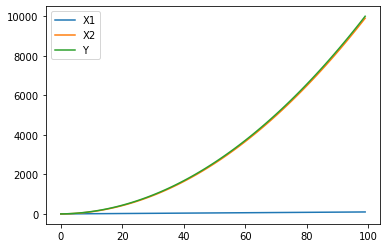

In [3]:
# Construct a simple linear curve of 1, 2, 3, ...
X1 = np.arange(100)

# Make a parabola and add X1 to it, this is X2
X2 = np.array([i ** 2 for i in range(100)]) + X1

# This is our real Y, constructed using a linear combination of X1 and X2
Y = X1 + X2

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(Y, label='Y')
plt.legend();

我们可以使用`statsmodels`中的相同函数，就像我们在单一线性回归课程中所做的那样。

In [4]:
# Use column_stack to combine independent variables, then add a column of ones so we can fit an intercept
X = sm.add_constant( np.column_stack( (X1, X2) ) )

# Run the model
results = regression.linear_model.OLS(Y, X).fit()

print('Beta_0:', results.params[0]) 
print('Beta_1:', results.params[1]) 
print ('Beta_2:', results.params[2])

Beta_0: 1.7905676941154525e-12
Beta_1: 1.0000000000003482
Beta_2: 0.9999999999999951


对这些结果的处理必须与对偏导数的处理一样谨慎。$Y$的公式显然是

$$X_1 + X_2 = X_1 + X^2 + X_1 = 2 X_1 + X^2$$

或者说$2X_1$加上一条抛物线。

但是，$X_1$的系数是1。这是因为在<i>保持$X_2$不变</i>的情况下，如果将$X_1$改变1，$Y$就会改变1。多元线性回归从不同的变量中分离出贡献。

类似地，对两种证券进行线性回归可能得到一个较高的$\beta$。然而，如果我们引入第三种证券(如SPY，它跟踪标准普尔500指数)作为一个独立变量，我们可能会发现，前两种证券之间的相关性几乎完全是因为它们都与标准普尔500指数相关。这是有用的，因为标准普尔500指数可能是对两种证券的更可靠的预测，而不是对彼此的预测。这种方法使我们能够更好地衡量这两种证券之间的重要性，并防止混淆这两个变量。

In [7]:
from pandas_datareader import data
# Load pricing data for two arbitrarily-chosen assets and SPY
start = '2014-01-01'
end = '2015-01-01'
asset1 = data.get_data_yahoo('ATT', start, end)['Close']
asset2 = data.get_data_yahoo('FISV', start, end)['Close']
benchmark = data.get_data_yahoo('SPY', start, end)['Close']

# First, run a linear regression on the two assets
slr = regression.linear_model.OLS(asset1, sm.add_constant(asset2)).fit()
print('SLR beta of asset2:', slr.params[1]) 

SLR beta of asset2: 3.173687260322235


D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [8]:
# Run multiple linear regression using asset2 and SPY as independent variables
mlr = regression.linear_model.OLS(asset1, sm.add_constant(np.column_stack((asset2, benchmark)))).fit()

prediction = mlr.params[0] + mlr.params[1]*asset2 + mlr.params[2]*benchmark
prediction.name = 'Prediction'

print('MLR beta of asset2:', mlr.params[1], '\nMLR beta of S&P 500:', mlr.params[2]) 

MLR beta of asset2: -2.124852332884781 
MLR beta of S&P 500: 1.7149767380558396


运行分析后的下一步是确定我们是否可以信任结果。好的第一步是检查在自变量、因变量和预测图中是否有奇怪的地方。

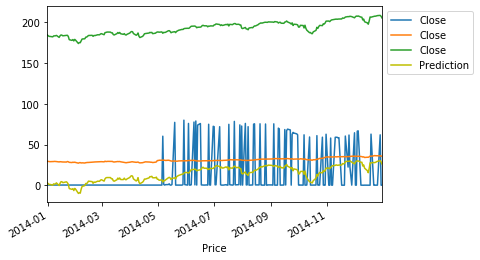

In [9]:
# Plot the three variables along with the prediction given by the MLR
asset1.plot()
asset2.plot()
benchmark.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend(bbox_to_anchor=(1,1), loc=2);

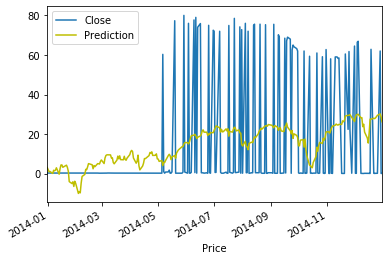

In [10]:
# Plot only the dependent variable and the prediction to get a closer look
asset1.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend();

# 评价

我们可以从回归结果中得到一些关于fit的统计数据:

In [11]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     16.03
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           2.82e-07
Time:                        22:04:45   Log-Likelihood:                -1183.0
No. Observations:                 253   AIC:                             2372.
Df Residuals:                     250   BIC:                             2383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -250.8896     55.282     -4.538      0.000    -359.767    -142.013
x1            -2.1249      1.759     -1.208      0.228      -5.589       1.340
x2             1.7150      0.524      3.272      0.001       0.683       2.747
==============================================================================
Omnibus:                       42.362   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.472
Skew:                           1.196   Prob(JB):                     7.39e-14
Kurtosis:                       3.102   Cond. No.                     6.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 模型的假设

这些统计数据的有效性取决于线性回归模型的假设是否得到满足。这些都是:
* 自变量不是随机的。
* 误差项的方差在各观测值之间是恒定的。这对于评价拟合优度很重要。
* 误差不是自相关的。由回归报告的Durbin-Watson统计数据检测到了这一点。如果它接近$2$，就不存在自相关。
* 误差是正态分布的。如果这不能成立，我们就不能使用一些统计数据，比如f检验。

多元线性回归还需要一个额外的假设:
* 独立变量之间没有确切的线性关系。否则，不可能唯一地求解系数$\beta_i$，因为相同的线性方程可以用多种方式表示。

如果任何一组自变量之间存在线性关系，也称为协方差，我们就说它们是彼此的线性组合。在它们以这种方式相互依赖的情况下，对于给定的$X_i$，我们的$\beta_i$系数的值将是不准确的。在极端例子中，$X_1$和$X_2$是100%协变的。在这种情况下，线性回归可以在不影响预测能力的情况下，在任何组合中等效地分配总系数和。

$$ 1X_1 + 0X_2 = 0.5X_1 + 0.5X_2 = 0X_1 + 1X_2 $$


虽然我们的系数可能是非描述性的，但如果自变量和因变量之间存在良好的整体拟合，最终的模型可能仍然是准确的。在依赖关系是一个问题的情况下，构建模型的最佳实践是忽略与较好变量相关的描述性较差的变量。这通过减少过度拟合的机会来改进模型，同时使$\beta_i$估计值更接近它们的真实值。

如果我们确认回归模型的必要假设是满足的，我们就可以安全地使用报告的统计数据来分析拟合。例如，$R^2$值告诉我们由模型解释的$Y$总变化的百分比。然而，在进行多元线性回归时，我们更倾向于使用调整后的$R^2$，这纠正了我们在模型中添加更多回归变量时出现的$R^2$的小幅增长，即使它们与因变量之间没有显著的相关性。调整后的R^2$定义为

$$ 1 - (1 - R^2)\frac{n-1}{n-k-1} $$

其中$n$是观测值的个数，$k$是模型中独立变量的个数。其他有用的统计数据包括f统计量和估计的标准误差。

# 模型选择的例子

在确定因变量的最佳模型时，有几种不同的方法可供参考。如果你使用了太多的解释变量，你就会有过度拟合你的模型的风险，但是如果你使用的太少，你可能会以一个可怕的拟合结束。确定最佳模型的最重要的方法之一是逐步回归。正向逐步回归从一个空模型开始，对每个单独的变量进行测试，选择模型质量最好的一个，通常用AIC或BIC(最低为最好)来衡量。然后，它一次添加一个剩余的变量，测试回归中解释变量的每个后续组合，并计算每一步的AIC或BIC值。在回归的最后，选择质量最好的模型(根据给定的度量)作为最终的最佳模型。然而，这也有局限性。它不会测试每一个可能的变量组合，因此，如果在执行算法时较早地取消某个特定变量，它可能会错过理论上的最佳模型。因此，逐步回归应该与您对模型的最佳判断结合使用。

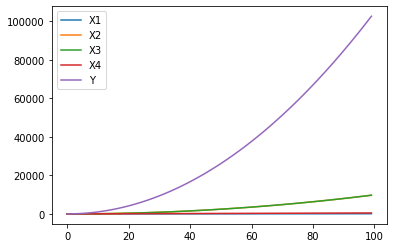

In [12]:
X1 = np.arange(100)
X2 = [i**2 for i in range(100)] - X1
X3 = [np.log(i) for i in range(1, 101)] + X2
X4 = 5 * X1
Y = 2 * X1 + 0.5 * X2 + 10 * X3 + X4

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(X3, label='X3')
plt.plot(X4, label='X4')
plt.plot(Y, label='Y')
plt.legend();

In [13]:
results = regression.linear_model.OLS(Y, sm.add_constant(np.column_stack((X1,X2,X3,X4)))).fit()

print("Beta_0: ", results.params[0]) 
print ("Beta_1: ", results.params[1])
print ("Beta_2: ", results.params[2])
print ("Beta_3: ", results.params[3])
print ("Beta_4: ", results.params[4])

Beta_0:  3.001332515850663e-11
Beta_1:  0.26923076923058
Beta_2:  0.5000000000113687
Beta_3:  9.999999999985903
Beta_4:  1.3461538461539675


In [14]:
data = pd.DataFrame(np.column_stack((X1,X2,X3,X4)), columns = ['X1','X2','X3','X4'])
response = pd.Series(Y, name='Y')

In [15]:
def forward_aic(response, data):
    # This function will work with pandas dataframes and series
    
    # Initialize some variables
    explanatory = list(data.columns)
    selected = pd.Series(np.ones(data.shape[0]), name="Intercept")
    current_score, best_new_score = np.inf, np.inf
    
    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:
        
        scores_with_elements = []
        count = 0
        
        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, data[element]], axis=1)
            # Test the set
            result = regression.linear_model.OLS(Y, tmp).fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1
        
        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, data[best_element]],axis=1)
            current_score = best_new_score
    # Return the final model
    model = regression.linear_model.OLS(response, selected).fit()
    return model

In [16]:
result = forward_aic(response, data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.885e+27
Date:                Sun, 19 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:10:11   Log-Likelihood:                 1791.1
No. Observations:                 100   AIC:                            -3574.
Df Residuals:                      96   BIC:                            -3564.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.183e-11   2.84e-09      0.011      0.991   -5.61e-09    5.67e-09
X3            10.0000   1.72e-09   5.82e+09      0.000      10.000      10.000
X4             1.3462   2.63e-11   5.13e+10      0.000       1.346       1.346
X2             0.5000   1.72e-09   2.91e+08      0.000       0.500       0.500
X1             0.2692   5.25e-12   5.13e+10      0.000       0.269       0.269
==============================================================================
Omnibus:                       14.191   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.970
Skew:                          -0.645   Prob(JB):                      0.00684
Kurtosis:                       2.147   Cond. No.                     6.78e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.29e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

在这个模型的构造中，$X_4$项与$X_1$项高度相关，只是将它乘以一个标量。但是，逐步回归并没有捕捉到这一点，而是删除了变量，并简单地调整了$X_1$项的系数。我们自己的判断是把$X_4$项从模型中去掉，这显示了逐步回归的局限性。

还有其他方法可以诊断模型的健康状况和对更复杂模型具有不同程度惩罚的个体变量。这将在模型选择的课程中深入讨论。